In [1]:
# Import modules
import sys
sys.path.append(r"c:/Users/Raees/Desktop/stuff/NuOscProbExact/src")


from oscprob2nu import *
from globaldefs import *
from hamiltonians2nu import *
from hamiltonians3nu import *
from oscprob3nu import *

import numpy as np 
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from scipy.integrate import simpson, quad
from scipy.interpolate import interp1d
import copy as cp
import builtins
import itertools
import scipy.linalg as la
from scipy.linalg import expm
import cmath
import sympy as sp

In [2]:
# Gaussian fit
def gaus(data, amplitude, mean, sigma):
    return amplitude * math.e**((-0.5 * (data - mean)**2) / sigma**2)

def fluctuated_fit(gaus, bin_centers, counts):
    popt, _ = curve_fit(gaus, bin_centers, counts)
    return popt

def param_values2(param=None, sigma_fraction=0.0):
    """
    Returns oscillation parameter values at a given fraction of their uncertainty.

    Args:
        param (str): Name of the parameter.
        sigma_fraction (float): Fraction of the uncertainty (-1 to 1 for ±1σ).

    Returns:
        float: Parameter value adjusted by the given fraction of uncertainty.
    """

    params = {
        'Dm2_21': (7.53e-5, 0.0),  # No uncertainty specified
        's2th12': (0.307, 0.0),  # No uncertainty specified
        's2th13': (0.0210, 0.0011),  # ± 0.0011
        'Dm2_32': (2.41e-3, 0.07e-3),  # ± 0.07e-3
        's2th23': (0.57, 0.03, 0.04),  # +0.03, -0.04
        'd_cp': (0.82 * np.pi, 0.27 * np.pi, 0.87 * np.pi)  # +0.27π, -0.87π
    }

    if param not in params:
        raise ValueError(f"Invalid parameter: {param}")

    central = params[param][0]

    if len(params[param]) == 2:
        uncertainty = params[param][1]

        if param in ['s2th13', 's2th12']:
            return np.sqrt(central + (sigma_fraction * uncertainty))
        else:

            return central + (sigma_fraction * uncertainty)

    elif len(params[param]) == 3:
        pos_unc = params[param][1]
        neg_unc = params[param][2]

        if param in ['s2th23']:
            return np.sqrt(central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc))
        else:
            return central + sigma_fraction * (pos_unc if sigma_fraction > 0 else neg_unc)

    return central

In [3]:
# Parameters
bin_centers = np.array([0.375, 0.875, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.125, 2.375, 2.6375, 2.8875, 3.25, 3.75, 4.5])
bin_edges = np.array([0, 0.75, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.25, 2.5, 2.775, 3, 3.5, 4, 5])

# Event counts for muon neutrino beam, muon-to-muon
counts_nd = np.array([5, 42, 72, 96, 120, 148, 170, 192, 208, 214, 212, 204, 170, 112, 66, 36, 16, 5, 1])
counts_fd = np.array([0, 3, 1, 3, 1, 2, 2, 4, 6, 9, 15, 12, 15.8, 10, 7, 9, 3.2, 2.8, 1.8])
adjusted_counts_fd = np.array([ 0.  ,  7.5 ,  1.  ,  3.  ,  1.  ,  2.  ,  2.  ,  4.  ,  6.  ,
        9.  , 15.  , 12.  , 39.5 , 25.  , 19.25, 20.25, 16.  , 14.  ,
       18.  ])
adjusted_counts_nd = np.array([ 37500., 105000.,  72000.,  96000., 120000., 148000., 170000.,
       192000., 208000., 214000., 212000., 204000., 425000., 280000.,
       181500.,  81000.,  80000.,  25000.,  10000.])

# Event counts for electron neutrio beam, muon-to-electron
counts_nd_e = np.array([0.01, 0.5, 2.4, 4.6, 4, 2.6, 1.8 ,1.4, 1.2])
adjusted_counts_nd_e = np.array([10, 500, 2400, 4600, 400, 2600, 1800, 1400, 1200])
counts_fd_e = np.array([5 ,21, 18, 4, 1, 1])
bin_centers_e = np.array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25])
bin_edges_e = np.array([0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5])

length_nd = 1 # [km]
length_fd = 810 # [km]

bin_widths = bin_edges[1:] - bin_edges[:-1]

# Event counts for antineutrino beam
anti_counts_nd = np.array([2.5, 20, 38.75, 45 ,67.5, 70, 85, 97.5, 107.5, 113.75, 115, 111.25, 95, 62.5, 37.5, 20, 10, 2.5, 0])
anti_counts_fd = np.array([0.25, 2, 1, 2, 0, 2, 3, 0, 0, 8, 3, 7, 4.4, 6, 2.4, 2, 2.4, 1.25, 1.75])
anti_counts_nd_e = np.array([0, 0.25, 1.3, 2.5, 2.52, 1.9, 1.35, 1.15, 0.95]) # The High CNN one, cause it might be better?
anti_counts_fd_e = np.array([1, 8, 5, 3, 1, 1])

adjusted_anti_counts_nd_e = np.array([0, 250, 1300, 2500, 2520, 1900, 1350, 1150, 950])
adjusted_anti_counts_nd = anti_counts_nd * (bin_widths / 0.1) * 1000
adjusted_anti_counts_fd = anti_counts_fd * (bin_widths / 0.1)

initial_guess = [140, 2, 0.5]

popt_nd, _ = curve_fit(gaus, bin_centers, counts_nd, p0=initial_guess)
print(f"Fitted parameters for observed the unoscillated ND events: Amplitude = {popt_nd[0]}, Mean = {popt_nd[1]}, Sigma = {popt_nd[2]}")


popt_nd_e, _ = curve_fit(gaus, bin_centers_e, counts_nd_e, p0=[5,2, 0.5])
print(f"Fitted parameters for observed the unoscillated ND electon events: Amplitude = {popt_nd_e[0]}, Mean = {popt_nd_e[1]}, Sigma = {popt_nd_e[2]}")

popt_anti_nd, _ = curve_fit(gaus, bin_centers, anti_counts_nd, p0=[120,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = {popt_anti_nd[0]}, Mean = {popt_anti_nd[1]}, Sigma = {popt_anti_nd[2]}")


popt_anti_nd_e, _ = curve_fit(gaus, bin_centers_e, anti_counts_nd_e, p0=[5,2,0.5])
print(f"Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = {popt_anti_nd_e[0]}, Mean = {popt_anti_nd_e[1]}, Sigma = {popt_anti_nd_e[2]}")

x = np.arange(0.01,5,0.01)

Fitted parameters for observed the unoscillated ND events: Amplitude = 212.76692701207105, Mean = 1.8044188236034169, Sigma = 0.525448417032163
Fitted parameters for observed the unoscillated ND electon events: Amplitude = 4.218662147714044, Mean = 2.1341687610051183, Sigma = 0.8475810459857663
Fitted parameters for observed the unoscillated antineutrino ND events: Amplitude = 113.1060196955553, Mean = 1.8355298839724858, Sigma = 0.5285564990530245
Fitted parameters for observed the unoscillated antineutrino ND electron events: Amplitude = 2.4344413635605364, Mean = 2.356842604598921, Sigma = 0.9997075655274238


In [4]:
def mixing_matrix_4nu_v2(s2th12, s2th23, s2th13, d_cp, neutrino, sterile, th14):

    c12 = math.sqrt(1 - s2th12**2)
    s12 = s2th12
    s23 = s2th23
    c23 = math.sqrt(1 - s2th23**2)
    s13 = s2th13
    c13 = math.sqrt(1 - s2th13**2)

    delta13 = d_cp

    if sterile:
        if neutrino:
            th24 = 25 # degrees
            th34 = 32 #degrees
            delta14, delta34 = 0, 0

        else:
            th24, th34 =  20.8, 31.2
            delta14, delta34 = 0,0
    else:
        th14,th24,th34 = 0,0,0
        delta14,delta34=0,0

    c14, s14 = np.cos(np.radians(th14)), np.sin(np.radians(th14))
    c24, s24 = np.cos(np.radians(th24)), np.sin(np.radians(th24))
    c34, s34 = np.cos(np.radians(th34)), np.sin(np.radians(th34))

    # mixing matrix from https://arxiv.org/pdf/2106.15945
    U = np.array([
    [c14*c13*c12, c14*c13*s12, c14*np.exp(-1j * delta13)*s13, np.exp(-1j * delta13)*s14],

    [(-c24*c23*s12 - (c24*s23*s13*c12*np.exp(-1j * delta13) - s24*s14*c13*c12*np.exp(-1j * delta14))),    
     (c24*c23*c12 - (c24*s23*s13*s12*np.exp(1j * delta13) - s24*s14*c13*s12*np.exp(1j * delta14))),
     (-c24*s23*c13 - s24*s14*s13*np.exp(-1j * (delta13-delta14))),
     s24*c14],

    [c34*s23*s12 - c34*c23*s13*c12*np.exp(1j * delta13) + s34*s24*c23*s12*np.exp(-1j * delta34) + s34*s24*s23*s13*c12*np.exp(-1j * (delta34-delta13)) - s34*c24*s14*c13*c12*np.exp(-1j * (delta34-delta14)),
     -c34*s23*c12 - c34*c23*s13*s12*np.exp(1j * delta13) - s34*s24*c23*c12*np.exp(-1j * delta34) + s34*s24*s23*s13*s12*np.exp(-1j * (delta34-delta13)) - s34*c24*s14*c13*s12*np.exp(-1j * (delta34-delta14)),
     c34*c23*c13 - s34*s24*s23*c13*np.exp(-1j * delta34) - s34*c24*s14*s13*np.exp(-1j * (delta13-delta14+delta34)),
     s34*c24*c14*np.exp(-1j * delta34)],

    [-s34*s23*s12*np.exp(1j * delta34) + s34*c23*s13*c12*np.exp(1j * (delta34+delta13)) + c34*s24*c23*s12 + c34*s24*s23*s12*c12*np.exp(1j * delta13) - c34*c24*s14*c13*c12*np.exp(1j * delta14),
     s34*s23*c12*np.exp(1j * delta34) + s34*c23*s13*s12*np.exp(1j * (delta34+delta13)) - c34*s24*c23*c12 + c34*s24*s23*s13*s12*np.exp(1j * delta13) - c34*c24*s14*c13*s12*np.exp(1j * delta14),
     -s34*c23*c13*np.exp(1j * delta34) - c34*s24*s23*c13 - c34*c24*s14*s13*np.exp(-1j * (delta13-delta14)),
     c34*c24*c14]
    ])
    return U

def hamiltonian_4nu_v2(s2th12, s2th23, s2th13, d_cp, Dm2_21, Dm2_32, th14, neutrino, sterile):
    Dm21 = Dm2_21
    Dm31 = Dm2_32
    if sterile:
        Dm41 = 0.5
    else:
        Dm41 = 0
    f = 1/2

    M2 = np.array([[0,0,0,0],[0,Dm21,0,0],[0,0,Dm31,0],[0,0,0,Dm41]]) # guessed mass matrix, using info for the 2x2 and 3x3 matrices
    R = np.array(mixing_matrix_4nu_v2(s2th12, s2th23, s2th13, d_cp, neutrino, sterile, th14))
    #print('Mixing matrix', R)
    H = list(f*np.matmul(R, np.matmul(M2, np.conj(matrix.transpose(R)))))
    return H

def hamiltonian_4nu_matter(hamiltonian, energy, VCC):
    H_matter = cp.deepcopy(hamiltonian)
    H_matter = np.multiply(1/energy, H_matter)
    H_matter[0][0] += VCC
    return H_matter

def evolution_operator_4nu(hamiltonian_matrix, L):
    """
    Computes the evolution operator U = exp(-i H L) for 4 neutrino flavors.
    """
    return expm(-1j * hamiltonian_matrix * L)

def probabilities_4nu(hamiltonian_matrix, L):
    """
    Computes the oscillation probabilities P(ν_α → ν_β) for a 4-flavor neutrino model.
    """
    U = evolution_operator_4nu(hamiltonian_matrix, L)

    Pee = abs(U[0, 0])**2
    Pem = abs(U[1, 0])**2
    Pet = abs(U[2, 0])**2
    Pes = abs(U[3, 0])**2

    Pme = abs(U[0, 1])**2
    Pmm = abs(U[1, 1])**2
    Pmt = abs(U[2, 1])**2
    Pms = abs(U[3, 1])**2

    Pte = abs(U[0, 2])**2
    Ptm = abs(U[1, 2])**2
    Ptt = abs(U[2, 2])**2
    Pts = abs(U[3, 2])**2

    Pse = abs(U[0, 3])**2
    Psm = abs(U[1, 3])**2
    Pst = abs(U[2, 3])**2
    Pss = abs(U[3, 3])**2

    return Pee, Pem, Pet, Pes, Pme,Pmm,Pmt,Pms,Pte,Ptm,Ptt,Pts,Pse,Psm,Pst,Pss

In [5]:
def osc_prob_4nu(type, case, length, transition, fractions, sterile=True):

    results = {}

    energy = x * 1e9
    length_scaled = length * CONV_KM_TO_INV_EV
    length_scaled_nd = 1 * CONV_KM_TO_INV_EV
    length_scaled_fd = 810 * CONV_KM_TO_INV_EV

    transition_map = {
        "Pee": 0, "Pem": 1, "Pet": 2, "Pes": 3,
        "Pme": 4, "Pmm": 5, "Pmt": 6, "Pms": 7,
        "Pte": 8, "Ptm": 9, "Ptt": 10, "Pts": 11,
        "Pse": 12, "Psm": 13, "Pst": 14, "Pss": 15
    }
    index = transition_map.get(transition)
    if index is None:
        raise ValueError(f"Invalid transition: {transition}")
    
    fixed_params = ['s2th12', 'Dm2_21']
    varying_params1 = ['s2th23', 's2th13', 'd_cp', 'Dm2_32']

    fixed_param_values = {param: param_values2(param, 0) for param in fixed_params}
    fraction_combinations = list(itertools.product(fractions, repeat=len(varying_params1)))

    bin_edge = bin_edges

    if type == 'neutrino':
        popt = popt_nd
        neutrino = True

    elif type == 'antineutrino':
        popt = popt_anti_nd
        neutrino = False

    else:
        raise ValueError(f"Invalid type '{type}'. Must be 'neutrino' or 'antineutrino'.")

    
    iterations = 0
    gaus_x = gaus(x, *popt)

    th14 = [0,5,10,15]
    for angle in th14:
        hamiltonians = {}
        counts_dict = {}
        size_dict = {}

        for fraction_values in fraction_combinations:
            param_values = {param: param_values2(param, frac) for param, frac in zip(varying_params1, fraction_values)}
            full_param_values = {**fixed_param_values, **param_values}
            
            if neutrino == True:

                hamiltonians[fraction_values] = hamiltonian_4nu_v2(
                full_param_values['s2th12'],
                full_param_values['s2th23'],
                full_param_values['s2th13'],
                full_param_values['d_cp'],
                full_param_values['Dm2_21'],
                full_param_values['Dm2_32'],
                angle, 
                neutrino,
                sterile
                )
            elif neutrino == False:
                hamiltonians[fraction_values] = hamiltonian_4nu_v2(
                full_param_values['s2th12'],
                full_param_values['s2th23'],
                full_param_values['s2th13'],
                full_param_values['d_cp'],
                full_param_values['Dm2_21'],
                full_param_values['Dm2_32'],
                angle, 
                neutrino,
                sterile
                )
                hamiltonians[fraction_values] = np.conj(hamiltonians[fraction_values])


            if case == 'vacuum':
                def calculate_hamiltonian(h, e): return h / e
            elif case == 'matter' and type == 'neutrino':
                def calculate_hamiltonian(h, e): return hamiltonian_4nu_matter(h, e, VCC_EARTH_CRUST)
            elif case == 'matter' and type == 'antineutrino':
                def calculate_hamiltonian(h,e): return hamiltonian_4nu_matter(h,e, - VCC_EARTH_CRUST)
            else:
                raise ValueError('Invalid case')

            probs = np.array([probabilities_4nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled)[index] for e in energy])
            label = f'{transition}'
            if index in [7, 3, 11]:  # Pms, Pes, Pts
                probs = 1- probs
                label = f'1 - {transition}'

            osc_prob = probs * gaus_x
            gaussian_func = interp1d(x, osc_prob, fill_value=0, bounds_error=False)

            areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
            bin_widths = np.diff(bin_edge)
            areas = np.array(areas)

            prob_mm_nd = np.array([probabilities_4nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_nd)[5] for e in energy])
            prob_mm_fd = np.array([probabilities_4nu(calculate_hamiltonian(hamiltonians[fraction_values], e), length_scaled_fd)[5] for e in energy])
            gaus_mm_nd, gaus_mm_fd = prob_mm_nd * gaus_x, prob_mm_fd * gaus_x

            scaling_factors = {
                ('antineutrino', None): (np.sum(adjusted_anti_counts_fd) / np.sum(adjusted_anti_counts_nd)) * (1000 * (np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd))),
                ('neutrino', None): (np.sum(adjusted_counts_fd) / np.sum(adjusted_counts_nd)) * (1000 * np.sum(gaus_mm_nd) / np.sum(gaus_mm_fd)),
            }

            if length == 810:
                factor = scaling_factors.get((type, index), scaling_factors.get((type, None), 1))
                counts = (areas / bin_widths) * factor

            elif length == 1:
                counts = areas / bin_widths
            else:
                raise ValueError('Invalid Length')
            
            counts_dict[fraction_values] = counts
            size_dict[fraction_values] = np.sum(counts)

        zero_fraction = tuple(0 for _ in varying_params1)
        if zero_fraction not in counts_dict:
            raise KeyError(f'Fraction {zero_fraction} not found in counts_dict.')
        count_at_zero = counts_dict[zero_fraction]
        highest_fraction = builtins.max(size_dict, key=size_dict.get)
        lowest_fraction = builtins.min(size_dict, key=size_dict.get)
        upper_counts = counts_dict[highest_fraction]
        lower_counts = counts_dict[lowest_fraction]
        
        # Stack all counts to build a distribution
        all_counts = np.array(list(counts_dict.values()))
        
        # Compute 68% confidence interval
        diff_upper = upper_counts - count_at_zero
        diff_lower = count_at_zero - lower_counts
        upper_bound_68 = (diff_upper * 0.68) + count_at_zero
        lower_bound_68 = -(diff_lower * 0.68) + count_at_zero
        
        upper_array = upper_bound_68 - count_at_zero
        lower_array = count_at_zero - lower_bound_68
        
        sys_err = np.abs([lower_array, upper_array])
        
        # Generate Poisson fluctuated counts
        fluc_counts = np.random.poisson(count_at_zero)
        
        
        # Plot histograms
        #plt.figure(figsize=(9, 6))
        #for counts in all_counts:
        #    iterations += 1
        #    plt.hist(bin_edge[:-1],bin_edge, weights=counts,  histtype='step', color='red', linewidth=0.5)

        #plt.hist(bin_edge[:-1], bin_edge, weights=all_counts[0], histtype='step', label=f'Fraction Variation [{iterations} Iterations]', color='red', linewidth=0.5)
        #plt.hist(bin_edge[:-1],bin_edge, weights=count_at_zero,  histtype='step', label='Central Value', color='blue', linewidth=2)
        #plt.hist(bin_edge[:-1],bin_edge, weights=lower_counts,  histtype='step', label='Lower Value', color='black', linewidth=1.5)
        #plt.hist(bin_edge[:-1],bin_edge, weights=upper_counts,  histtype='step', label='Upper Value', color='black', linewidth=1.5)
        #plt.hist(bin_edge[:-1],bin_edge, weights=lower_bound_68,  histtype='step', label=r'68% Lower Value', color='green', linewidth=1)
        #plt.hist(bin_edge[:-1],bin_edge, weights=upper_bound_68,  histtype='step', label=r'68% Upper Value', color='green', linewidth=1)
        #plt.xlabel('Energy (GeV)')
        #plt.ylabel('Events')
        #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        #plt.title(f'Distribution of ({label}) Events Across Different Parameters In {case.capitalize()}')
        #plt.tight_layout()
        #plt.show()

        results[angle] = {
            'count_at_zero': np.array(count_at_zero),
            'sys_err': sys_err,
            'fluc_counts': fluc_counts,
            'probs': np.array(probs)
        }
    
    return results




In [6]:
fractions = [0]
results = osc_prob_4nu('neutrino', 'vacuum', length_fd, 'Pme', fractions)
results2 = osc_prob_4nu('neutrino', 'matter', length_fd, 'Pme', fractions)

results3 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pms', fractions)
results4 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pmm', fractions)

results5 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pes', fractions)
results6 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pee', fractions)
results7 = osc_prob_4nu('neutrino', 'vacuum', length_fd, 'Pme', fractions, sterile=False)
results8 = osc_prob_4nu('neutrino', 'matter', length_fd, 'Pme', fractions, sterile=False)

results9 = osc_prob_4nu('antineutrino', 'vacuum', length_fd, 'Pme', fractions, sterile=False)
results10 = osc_prob_4nu('antineutrino', 'matter', length_fd, 'Pme', fractions, sterile=False)


results11 = osc_prob_4nu('antineutrino', 'vacuum', length_nd, 'Pme', fractions, sterile=False)
results12 = osc_prob_4nu('antineutrino', 'matter', length_nd, 'Pme', fractions, sterile=False)

results13 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pme', fractions, sterile=False)
results14 = osc_prob_4nu('neutrino', 'matter', length_nd, 'Pme', fractions, sterile=False)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


In [7]:
results15 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pme', fractions) # compare with results5


C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


In [8]:
results16 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pem', fractions)
results17 = osc_prob_4nu('neutrino', 'matter', length_nd, 'Pem', fractions)

results18 = osc_prob_4nu('neutrino', 'vacuum', length_nd, 'Pet', fractions)
results19 = osc_prob_4nu('neutrino', 'matter', length_nd, 'Pet', fractions)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


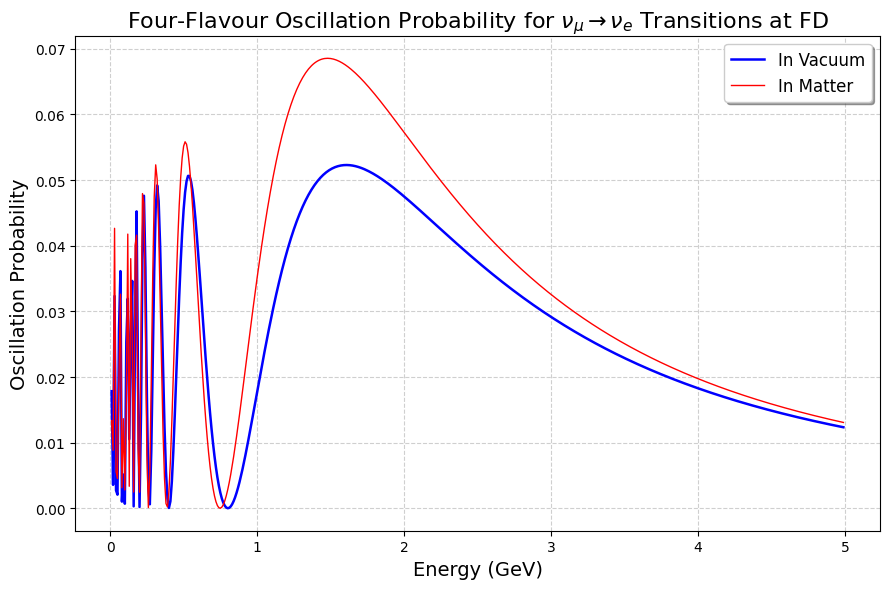

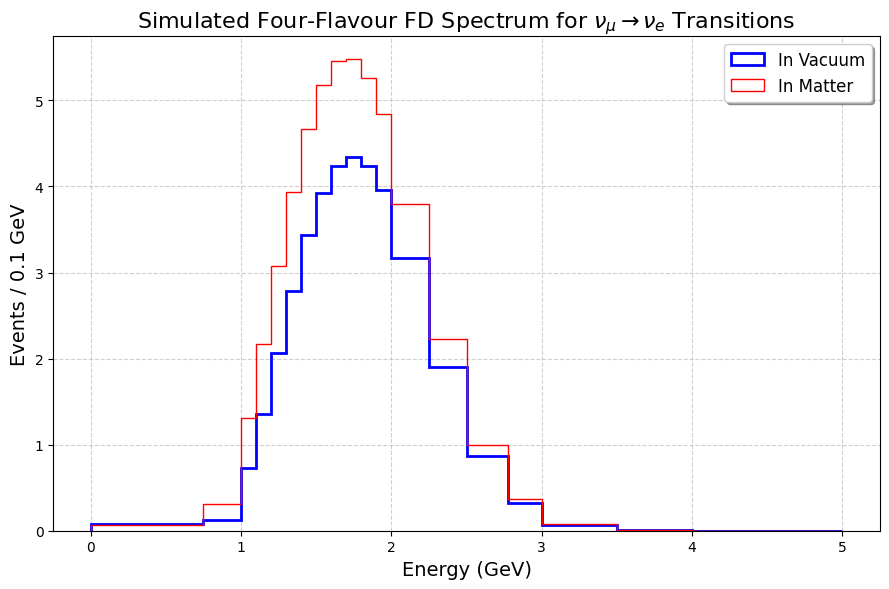

In [9]:
counts, err, _, prob =  results[10].values()

c1, e1, fc1, p1 = results7[0].values()
c2, e2, fc2, p2 = results8[0].values()


plt.figure(figsize=(9,6))
plt.plot(x, p1, label=r'In Vacuum', linewidth=1.8, color='b')
plt.plot(x, p2, label='In Matter', linewidth=1, color='r')
title = r'Four-Flavour Oscillation Probability for $\nu _\mu\, \to\, \nu _e$ Transitions at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c1, histtype='step', label=r'In Vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c2, histtype='step', label=r'In Matter', linewidth=1, color='red')
title = r'Simulated Four-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

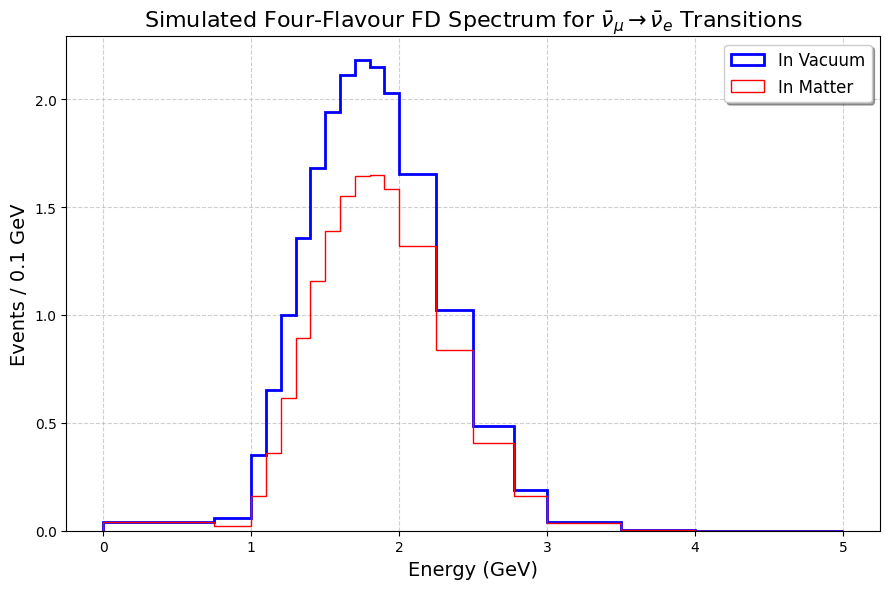

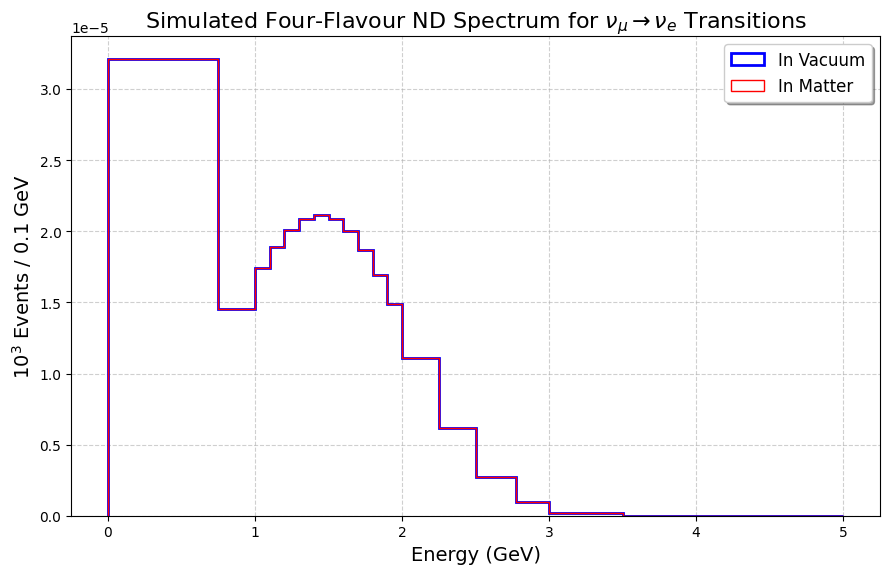

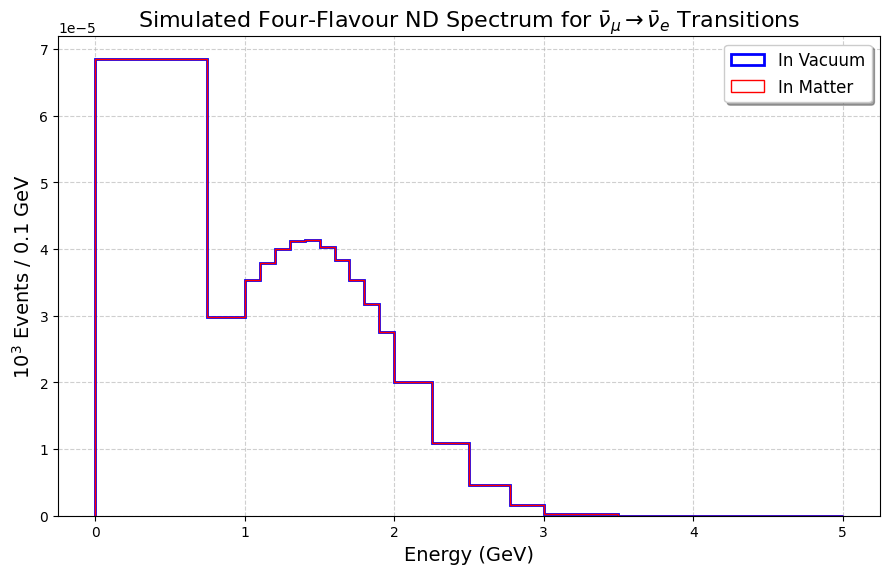

In [10]:
counts9,_,_,_ = results9[0].values()
counts10,_,_,_ = results10[0].values()

counts11,_,_,_ = results11[0].values()
counts12,_,_,_ = results12[0].values()

counts13,_,_,_ = results13[0].values()
counts14,_,_,_ = results14[0].values()

#plt.figure(figsize=(9,6))
#plt.hist(bin_edges[:-1], bin_edges, weights=counts7, histtype='step', label=r'In Vacuum', linewidth=2, color='blue')
#plt.hist(bin_edges[:-1], bin_edges, weights=counts8, histtype='step', label=r'In Matter', linewidth=1, color='red')
#title = r'Simulated Four-Flavour FD Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
#plt.title(title, fontsize=16)
#plt.ylabel(r'Events / 0.1 GeV', fontsize=14)
#plt.xlabel('Energy (GeV)', fontsize=14)
#plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
#plt.grid(True, linestyle='--', alpha=0.6)
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts9, histtype='step', label=r'In Vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts10, histtype='step', label=r'In Matter', linewidth=1, color='red')
title = r'Simulated Four-Flavour FD Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts11, histtype='step', label=r'In Vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts12, histtype='step', label=r'In Matter', linewidth=1, color='red')
title = r'Simulated Four-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=counts13, histtype='step', label=r'In Vacuum', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=counts14, histtype='step', label=r'In Matter', linewidth=1, color='red')
title = r'Simulated Four-Flavour ND Spectrum for $\bar{\nu} _\mu \,\to\, \bar{\nu} _e$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

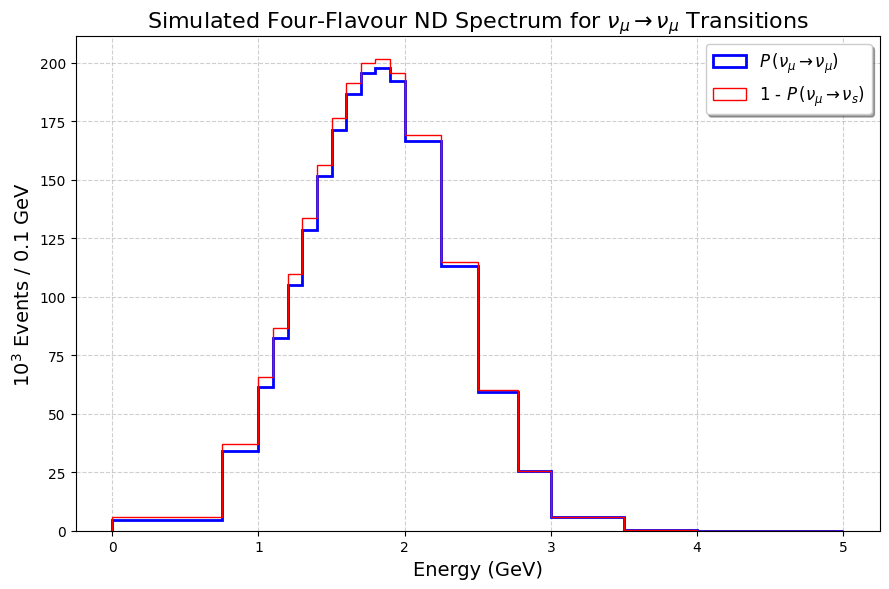

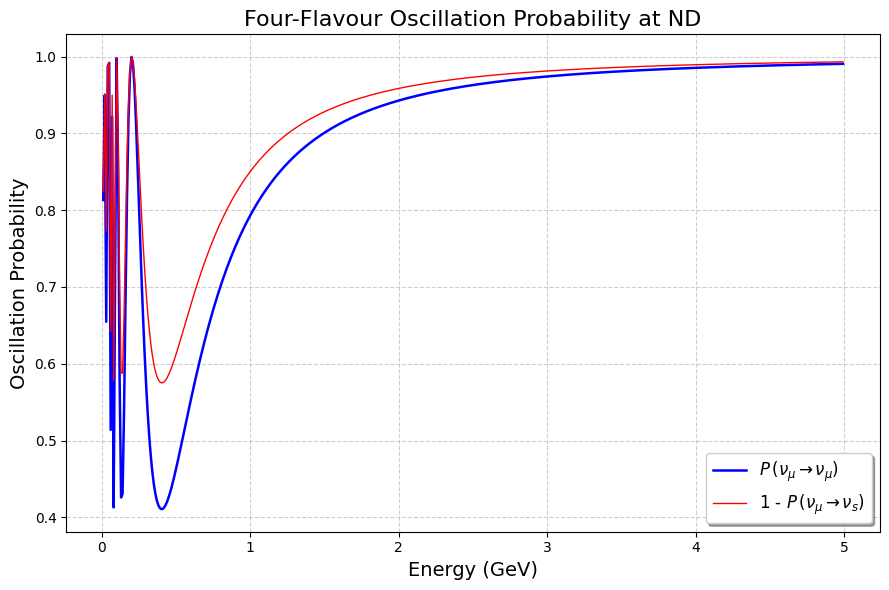

In [11]:
c3, e3, fc3, p3 = results3[0].values()
c4, e4, fc4, p4 = results4[0].values()


plt.figure(figsize=(9,6))
plt.hist(bin_edges[:-1], bin_edges, weights=c4, histtype='step', label=r'$P\,(\nu _\mu \,\to\, \nu _\mu)$', linewidth=2, color='blue')
plt.hist(bin_edges[:-1], bin_edges, weights=c3, histtype='step', label=r'1 - $P\,(\nu _\mu \,\to\, \nu _s)$', linewidth=1, color='red')
title = r'Simulated Four-Flavour ND Spectrum for $\nu _\mu \,\to\, \nu _\mu$ Transitions'
plt.title(title, fontsize=16)
plt.ylabel(r'$10^3$ Events / 0.1 GeV', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, p4, label=r'$P\,(\nu _\mu \,\to\, \nu _\mu)$', linewidth=1.8, color='b')
plt.plot(x, p3, label=r'1 - $P\,(\nu _\mu \,\to\, \nu _s)$', linewidth=1, color='r')
title = r'Four-Flavour Oscillation Probability at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="best", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
#https://arxiv.org/pdf/2409.04553

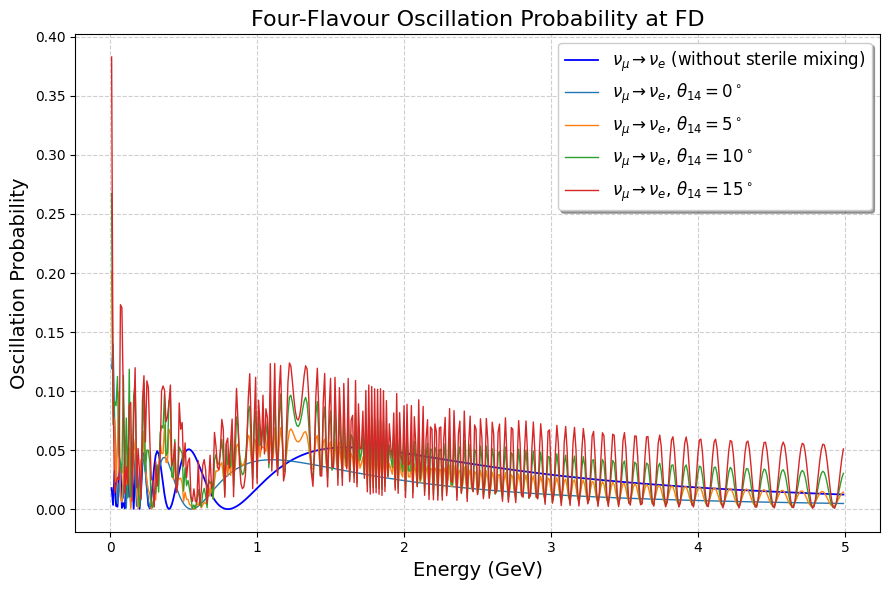

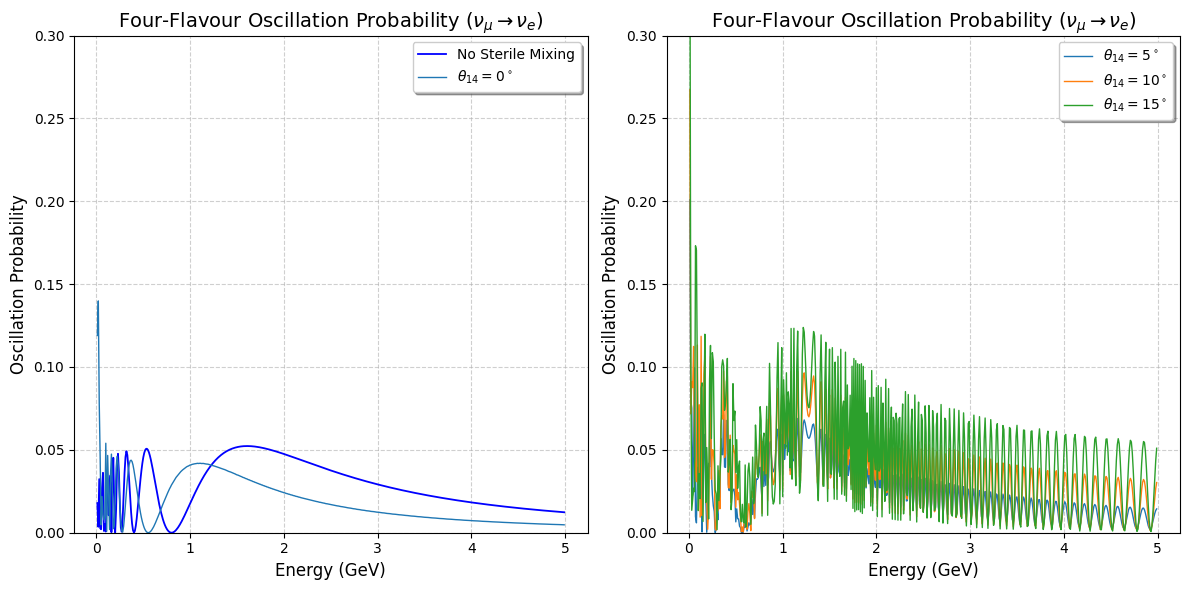

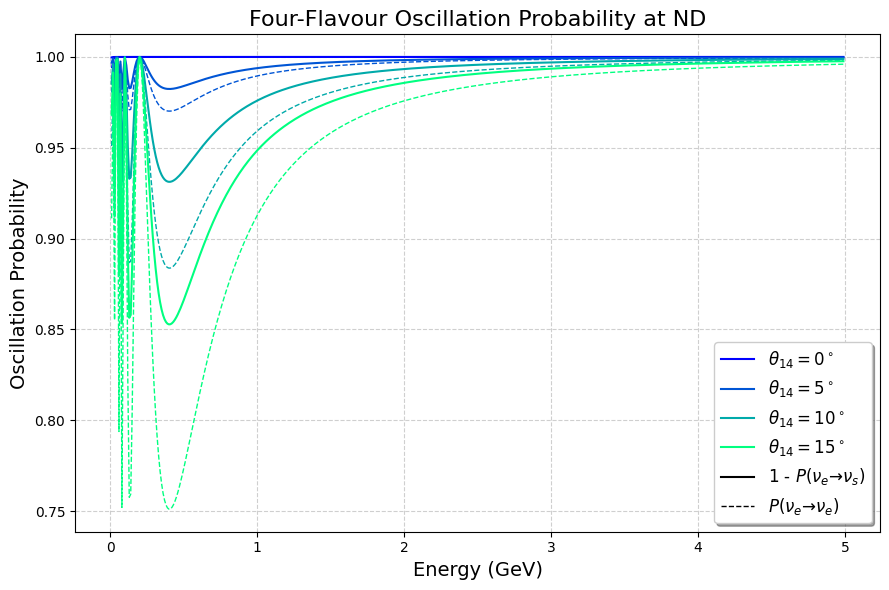

In [12]:
c5, e5, fc5, p5 = results[0].values()
c6, e6, fc6, p6 = results7[0].values()

c7, e7, fc7, p7 = results15[0].values()
c8, e8, fc8, p8 = results5[10].values()

plt.figure(figsize=(9,6))
angles = [0, 5, 10, 15]
plt.plot(x, p6  , label=r'$\nu _\mu\, \to\, \nu _e$ (without sterile mixing)', linewidth=1.3, color='b')
for i in angles:
    c6, e6, fc6, pi = results[i].values()
    plt.plot(x, pi, label=fr'$\nu _\mu\, \to\, \nu _e$, $\theta_{{14}} = {i}^\circ$', linewidth=1.)
#plt.plot(x, prob16, label=r'$\nu _e\, \to\, \nu _s$', linewidth=1, color='r')
title = r'Four-Flavour Oscillation Probability at FD'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# First subplot (first two plots)
plt.subplot(1, 2, 1)
plt.plot(x, p6, label=r'No Sterile Mixing', linewidth=1.3, color='b')
c6, e6, fc6, pi = results[0].values()
plt.plot(x, pi, label=fr'$\theta_{{14}} = 0^\circ$', linewidth=1.)
plt.title(r'Four-Flavour Oscillation Probability ($\nu _\mu\, \to\, \nu _e$)', fontsize=14)
plt.ylabel('Oscillation Probability', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)
plt.legend(fontsize=10, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0,0.3)
# Second subplot (remaining three plots)
plt.subplot(1, 2, 2)
for i in angles[1:]:  # Looping through the remaining angles
    c6, e6, fc6, pi = results[i].values()
    plt.plot(x, pi, label=fr'$\theta_{{14}} = {i}^\circ$', linewidth=1.)
plt.title(r'Four-Flavour Oscillation Probability ($\nu _\mu\, \to\, \nu _e$)', fontsize=14)
plt.ylabel('Oscillation Probability', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)
plt.legend(fontsize=10, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0,0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(9, 6))
angles = [0, 5, 10, 15]
colors = plt.cm.winter(np.linspace(0, 1, len(angles)))  # Generate colors for each angle

for i, color in zip(angles, colors):
    ci, ei, fci, pi = results5[i].values()
    ci2, ei2, fci2, pi2 = results6[i].values()

    # Solid line for 1 - P(ν_e → ν_s)
    plt.plot(x, pi, color=color, linewidth=1.5, label=fr'$\theta_{{14}} = {i}^\circ$')

    # Dashed line for P(ν_e → ν_e), sharing the same color
    plt.plot(x, pi2, color=color, linewidth=1, linestyle='--')

# Add labels only once for the different oscillation probabilities
plt.plot([], [], color='black', linewidth=1.5, label=r'1 - $P(\nu_e \to \nu_s)$')
plt.plot([], [], color='black', linewidth=1, linestyle='--', label=r'$P(\nu_e \to \nu_e)$')

# Set title, labels, and legend
plt.title(r'Four-Flavour Oscillation Probability at ND', fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="best", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


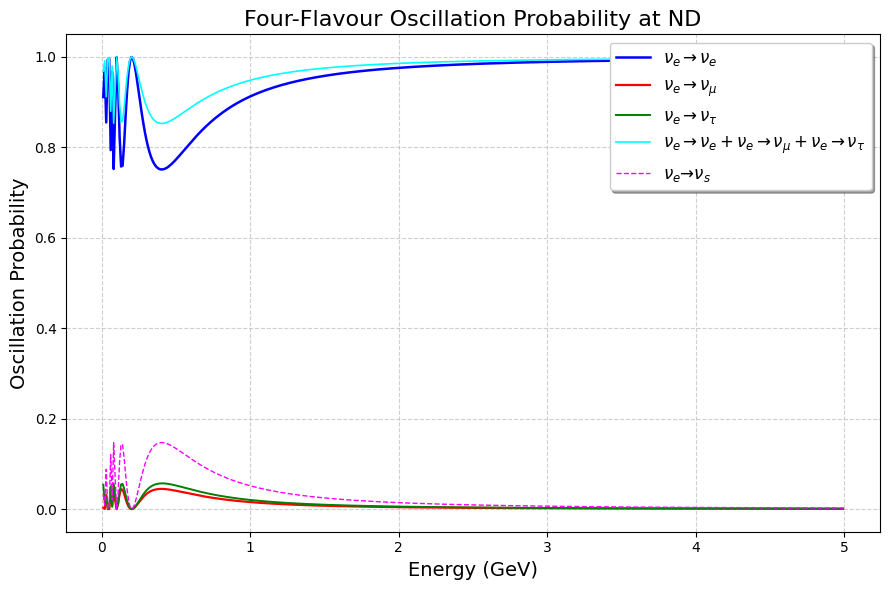

In [13]:
c6, e6, fc6, p6 = results6[15].values()
c9, _, _, p9 = results16[15].values()
c10, _, _, p10 = results18[15].values()

plt.figure(figsize=(9,6))
plt.plot(x, p6  , label=r'$\nu _e\, \to\, \nu _e$', linewidth=1.8, color='b')
plt.plot(x, p9, label=r'$\nu _e\, \to\, \nu _\mu$', linewidth=1.6, color='r')
plt.plot(x, p10, label=r'$\nu _e\, \to\, \nu _\tau$', linewidth=1.4, color='g')
plt.plot(x, p6+p9+p10, label=r'$\nu _e\, \to\, \nu _e + \nu _e\, \to\, \nu _\mu + \nu _e\, \to\, \nu _\tau$', linewidth=1.2, color='cyan')
plt.plot(x, 1 - (p6 + p9 + p10), label=r'$\nu_e \to \nu_s$', linestyle='--', color='magenta', linewidth = 1)
#plt.plot(x, p8, label=r'1 - $P\,(\nu _e \,\to\, \nu _s)$', linewidth=1)


title = r'Four-Flavour Oscillation Probability at ND'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
results20 = osc_prob_4nu('antineutrino' ,'vacuum', length_fd, 'Pme', fractions)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


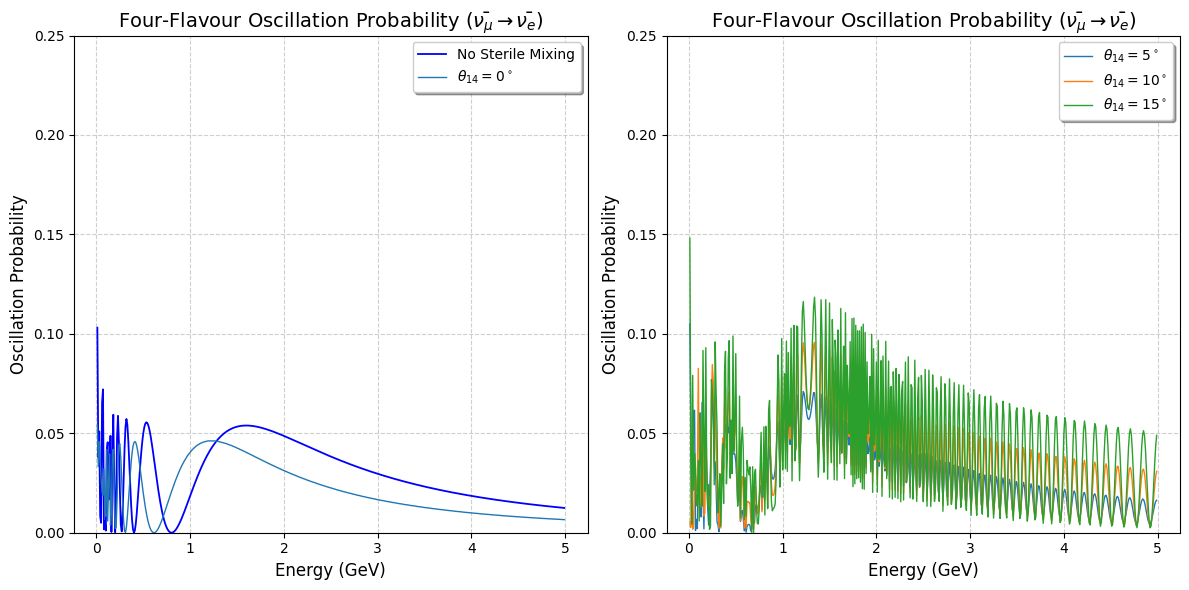

In [15]:
c9, e9, fc9, p9 = results9[0].values()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, p9, label=r'No Sterile Mixing', linewidth=1.3, color='b')
c20, e20, fc20, p20 = results20[0].values()
plt.plot(x, p20, label=fr'$\theta_{{14}} = 0^\circ$', linewidth=1.)
plt.title(r'Four-Flavour Oscillation Probability ($\bar{\nu _\mu}\, \to\, \bar{\nu _e}$)', fontsize=14)
plt.ylabel('Oscillation Probability', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)
plt.legend(fontsize=10, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0,0.25)
# Second subplot (remaining three plots)
plt.subplot(1, 2, 2)
for i in angles[1:]:  # Looping through the remaining angles
    c6, e6, fc6, pi = results20[i].values()
    plt.plot(x, pi, label=fr'$\theta_{{14}} = {i}^\circ$', linewidth=1.)
plt.title(r'Four-Flavour Oscillation Probability ($\bar{\nu _\mu}\, \to\, \bar{\nu _e}$)', fontsize=14)
plt.ylabel('Oscillation Probability', fontsize=12)
plt.xlabel('Energy (GeV)', fontsize=12)
plt.legend(fontsize=10, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0,0.25)
plt.tight_layout()
plt.show()

In [16]:
results20 = osc_prob_4nu('antineutrino' ,'vacuum', length_nd, 'Pee', fractions)
results21 = osc_prob_4nu('antineutrino' ,'vacuum', length_nd, 'Pem', fractions)
results22 = osc_prob_4nu('antineutrino' ,'vacuum', length_nd, 'Pet', fractions)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


In [17]:
results26 = osc_prob_4nu('antineutrino' ,'matter', length_nd, 'Pee', fractions)
results27 = osc_prob_4nu('antineutrino' ,'matter', length_nd, 'Pem', fractions)
results28 = osc_prob_4nu('antineutrino' ,'matter', length_nd, 'Pet', fractions)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


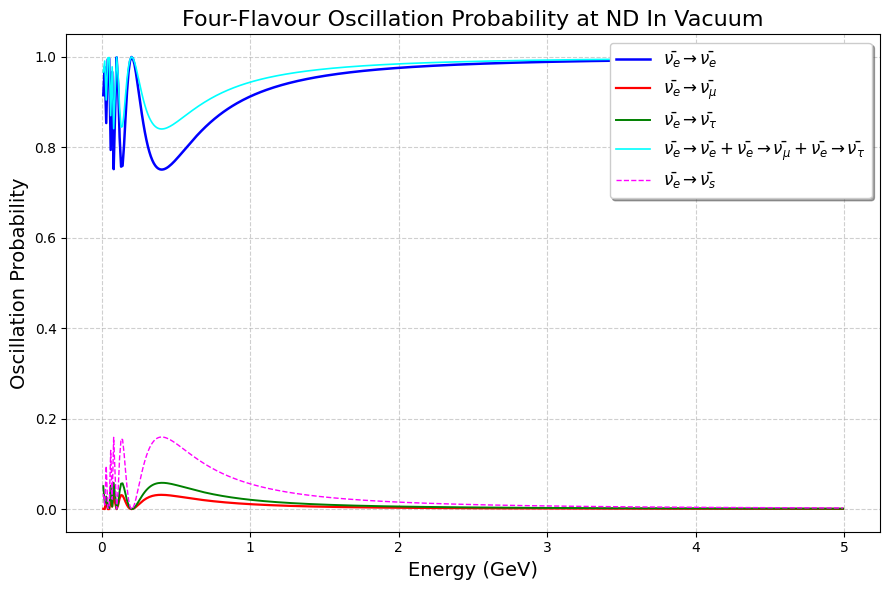

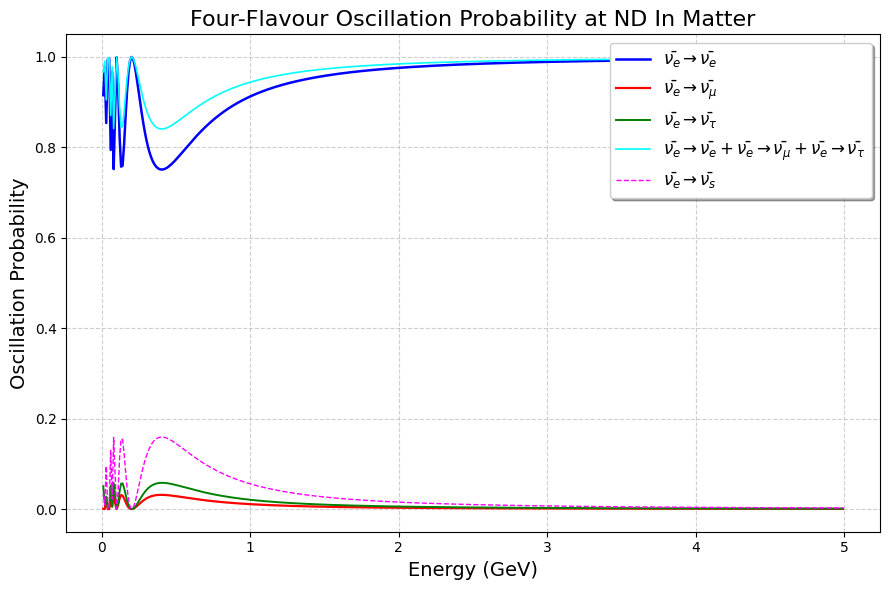

In [18]:
c20, e20, fc20, p20 = results20[15].values()
c21, _, _, p21 = results21[15].values()
c22, _, _, p22 = results22[15].values()

plt.figure(figsize=(9,6))
plt.plot(x, p20  , label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e}$', linewidth=1.8, color='b')
plt.plot(x, p21, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\mu}$', linewidth=1.6, color='r')
plt.plot(x, p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.4, color='g')
plt.plot(x, p20+p21+p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e} + \bar{\nu _e}\, \to\, \bar{\nu _\mu} + \bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.2, color='cyan')
plt.plot(x, 1 - (p20 + p21 + p22), label=r'$\bar{\nu _e}\, \to\, \bar{\nu _s}$', linestyle='--', color='magenta', linewidth = 1)
#plt.plot(x, p8, label=r'1 - $P\,(\nu _e \,\to\, \nu _s)$', linewidth=1)


title = r'Four-Flavour Oscillation Probability at ND In Vacuum'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


c20, e20, fc20, p20 = results26[15].values()
c21, _, _, p21 = results27[15].values()
c22, _, _, p22 = results28[15].values()

plt.figure(figsize=(9,6))
plt.plot(x, p20  , label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e}$', linewidth=1.8, color='b')
plt.plot(x, p21, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\mu}$', linewidth=1.6, color='r')
plt.plot(x, p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.4, color='g')
plt.plot(x, p20+p21+p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e} + \bar{\nu _e}\, \to\, \bar{\nu _\mu} + \bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.2, color='cyan')
plt.plot(x, 1 - (p20 + p21 + p22), label=r'$\bar{\nu _e}\, \to\, \bar{\nu _s}$', linestyle='--', color='magenta', linewidth = 1)
#plt.plot(x, p8, label=r'1 - $P\,(\nu _e \,\to\, \nu _s)$', linewidth=1)


title = r'Four-Flavour Oscillation Probability at ND In Matter'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [19]:
results23 = osc_prob_4nu('neutrino' ,'matter', length_nd, 'Pee', fractions)
results24 = osc_prob_4nu('neutrino' ,'matter', length_nd, 'Pem', fractions)
results25 = osc_prob_4nu('neutrino' ,'matter', length_nd, 'Pet', fractions)

C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]
C:\Users\Raees\AppData\Local\Temp\ipykernel_45320\2765355186.py:99: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  areas = [quad(gaussian_func, bin_edge[i], bin_edge[i+1])[0] for i in range(len(bin_edge) - 1)]


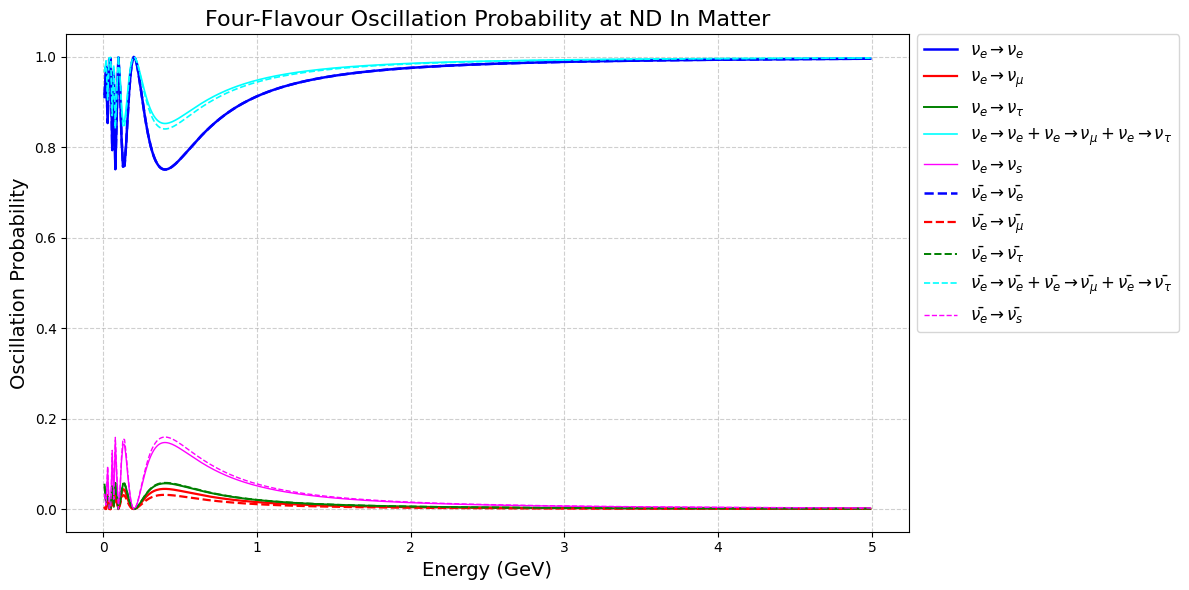

In [22]:

c20, e20, fc20, p20 = results23[15].values()
c21, _, _, p21 = results24[15].values()
c22, _, _, p22 = results25[15].values()

plt.figure(figsize=(12,6))
plt.plot(x, p20  , label=r'$\nu _e\, \to\, \nu _e$', linewidth=1.8, color='b')
plt.plot(x, p21, label=r'$\nu _e\, \to\, \nu _\mu$', linewidth=1.6, color='r')
plt.plot(x, p22, label=r'$\nu _e\, \to\, \nu _\tau$', linewidth=1.4, color='g')
plt.plot(x, p20+p21+p22, label=r'$\nu _e\, \to\, \nu _e + \nu _e\, \to\, \nu _\mu + \nu _e\, \to\, \nu _\tau$', linewidth=1.2, color='cyan')
plt.plot(x, 1 - (p20 + p21 + p22), label=r'$\nu _e\, \to\, \nu _s$', linestyle='-', color='magenta', linewidth = 1)

c20, e20, fc20, p20 = results26[15].values()
c21, _, _, p21 = results27[15].values()
c22, _, _, p22 = results28[15].values()


plt.plot(x, p20  , label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e}$', linewidth=1.8, color='b', linestyle='--')
plt.plot(x, p21, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\mu}$', linewidth=1.6, color='r', linestyle='--')
plt.plot(x, p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.4, color='g', linestyle='--')
plt.plot(x, p20+p21+p22, label=r'$\bar{\nu _e}\, \to\, \bar{\nu _e} + \bar{\nu _e}\, \to\, \bar{\nu _\mu} + \bar{\nu _e}\, \to\, \bar{\nu _\tau}$', linewidth=1.2, color='cyan',linestyle='--')
plt.plot(x, 1 - (p20 + p21 + p22), label=r'$\bar{\nu _e}\, \to\, \bar{\nu _s}$', linestyle='--', color='magenta', linewidth = 1)
#plt.plot(x, p8, label=r'1 - $P\,(\nu _e \,\to\, \nu _s)$', linewidth=1)


title = r'Four-Flavour Oscillation Probability at ND In Matter'
plt.title(title, fontsize=16)
plt.ylabel('Oscillation Probability', fontsize=14)
plt.xlabel('Energy (GeV)', fontsize=14)
plt.legend(fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()